In [3]:
# PINN for Burgers' equation
# coded by St.Watermelon

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [4]:
class Burgers(Model):

    def __init__(self):
        super(Burgers, self).__init__()

        self.h1 = Dense(20, activation='tanh')
        self.h2 = Dense(20, activation='tanh')
        self.h3 = Dense(20, activation='tanh')
        self.h4 = Dense(20, activation='tanh')
        self.h5 = Dense(20, activation='tanh')
        self.h6 = Dense(20, activation='tanh')
        self.u = Dense(1, activation='linear')


    def call(self, state):
        x = self.h1(state)
        x = self.h2(x)
        x = self.h3(x)
        x = self.h4(x)
        x = self.h5(x)
        x = self.h6(x)
        out = self.u(x)
        return out

In [5]:
class Pinn(object):

    def __init__(self):

        self.lr = 0.001
        self.opt = Adam(self.lr)

        self.burgers = Burgers()
        self.burgers.build(input_shape=(None, 2))

    def physics_net(self, xt):
        x = xt[:, 0:1]
        t = xt[:, 1:2]

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(t)
            tape.watch(x)
            xt_t = tf.concat([x,t], axis=1)
            u = self.burgers(xt_t)
            u_x = tape.gradient(u, x)
        u_xx = tape.gradient(u_x, x)
        u_t = tape.gradient(u, t)
        del tape

        return u_t + u*u_x - (0.01/np.pi)*u_xx


    def save_weights(self, path):
        self.burgers.save_weights(path + 'a.weights.h5')


    def load_weights(self, path):
        self.burgers.load_weights(path + 'a.weights.h5')


    def learn(self, xt_col, xt_bnd, tu_bnd):
        with tf.GradientTape() as tape:
            f = self.physics_net(xt_col)
            loss_col = tf.reduce_mean(tf.square(f))

            tu_bnd_hat = self.burgers(xt_bnd)
            loss_bnd = tf.reduce_mean(tf.square(tu_bnd_hat-tu_bnd))

            loss = loss_col + loss_bnd

        grads = tape.gradient(loss, self.burgers.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.burgers.trainable_variables))

        return loss, loss_col


    def predict(self, xt):
        tu = self.burgers(xt)
        return tu


    def train(self, max_num):

        # initial and boundary condition
        x_data = np.linspace(-1.0, 1.0, 500)
        t_data = np.linspace(0.0, 1.0, 500)
        xt_bnd_data = []
        tu_bnd_data = []

        for x in x_data:
            xt_bnd_data.append([x, 0])
            tu_bnd_data.append([-np.sin(np.pi * x)])

        for t in t_data:
            xt_bnd_data.append([1, t])
            tu_bnd_data.append([0])
            xt_bnd_data.append([-1, t])
            tu_bnd_data.append([0])

        xt_bnd_data = np.array(xt_bnd_data)
        tu_bnd_data = np.array(tu_bnd_data)

        # collocation point
        t_col_data = np.random.uniform(0, 1, [20000, 1])
        x_col_data = np.random.uniform(-1, 1, [20000, 1])
        xt_col_data = np.concatenate([x_col_data, t_col_data], axis=1)
        xt_col_data = np.concatenate((xt_col_data, xt_bnd_data), axis=0)

        train_loss_history = []
        train_loss_history2 = []

        for iter in range(int(max_num)):

            loss, loss2 = self.learn(tf.convert_to_tensor(xt_col_data, dtype=tf.float32),
                       tf.convert_to_tensor(xt_bnd_data, dtype=tf.float32),
                       tf.convert_to_tensor(tu_bnd_data, dtype=tf.float32))

            train_loss_history.append([iter, loss.numpy()])
            train_loss_history2.append([iter, loss2.numpy()])

            print('iter=', iter, ', loss=', loss.numpy())

        self.save_weights("./save_weights/")

        np.savetxt('./save_weights/loss.txt', train_loss_history)
        np.savetxt('./save_weights/loss2.txt', train_loss_history2)
        train_loss_history = np.array(train_loss_history)
        train_loss_history2 = np.array(train_loss_history2)

        plt.plot(train_loss_history[:, 0], train_loss_history[:, 1])
        plt.yscale("log")
        plt.show()

        plt.plot(train_loss_history2[:, 0], train_loss_history2[:, 1])
        plt.yscale("log")
        plt.show()

/opt/anaconda3/envs/pinn_tutorial/lib/python3.10/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'burgers', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


iter= 0 , loss= 0.8693151
iter= 1 , loss= 0.7232938
iter= 2 , loss= 0.60092556
iter= 3 , loss= 0.49890485
iter= 4 , loss= 0.41427225
iter= 5 , loss= 0.34450215
iter= 6 , loss= 0.28753185
iter= 7 , loss= 0.24175988
iter= 8 , loss= 0.2060098
iter= 9 , loss= 0.17942607
iter= 10 , loss= 0.16132216
iter= 11 , loss= 0.15100755
iter= 12 , loss= 0.14760154
iter= 13 , loss= 0.1498563
iter= 14 , loss= 0.15605389
iter= 15 , loss= 0.16410327
iter= 16 , loss= 0.17190784
iter= 17 , loss= 0.17783515
iter= 18 , loss= 0.1809972
iter= 19 , loss= 0.18124132
iter= 20 , loss= 0.17895749
iter= 21 , loss= 0.1748378
iter= 22 , loss= 0.16966791
iter= 23 , loss= 0.1641783
iter= 24 , loss= 0.15895699
iter= 25 , loss= 0.15441257
iter= 26 , loss= 0.15077475
iter= 27 , loss= 0.1481179
iter= 28 , loss= 0.14639659
iter= 29 , loss= 0.14548437
iter= 30 , loss= 0.14520983
iter= 31 , loss= 0.14538693
iter= 32 , loss= 0.14583784
iter= 33 , loss= 0.14640844
iter= 34 , loss= 0.1469769
iter= 35 , loss= 0.1474566
iter= 36 , l

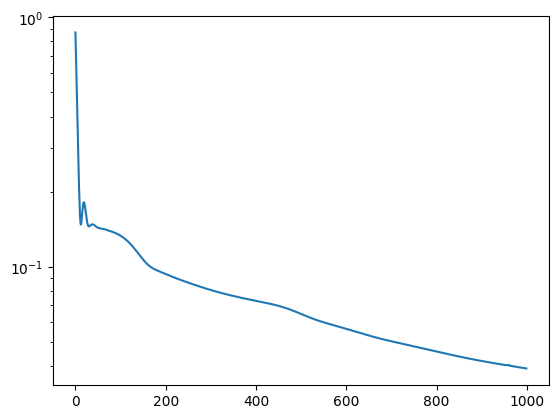

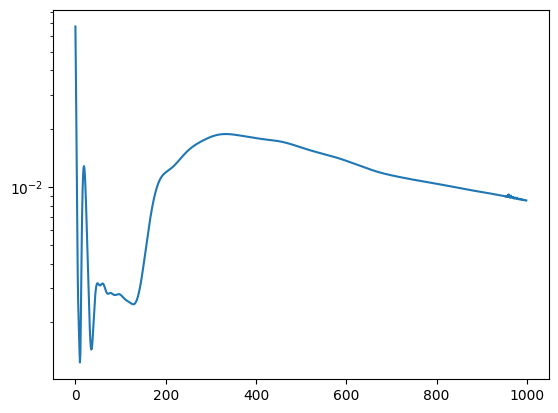

In [6]:
max_num = 1000
agent = Pinn()

agent.train(max_num)